### **Import Tools**

In [313]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold,cross_validate,train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from abc import ABC,abstractmethod
from sklearn import tree
from sklearn.metrics import confusion_matrix


### **Build random forest base class** and **Make Bootstrap samples**

In [314]:
class RandomForest(ABC):
    def __init__(self, n_trees=100): # mặc định 100 cây
        self.n_trees = n_trees
        self.tree = []
    def __make_bootstrap(self,data):
        # khởi tạo output dictionary và unique count
        dc = {}
        unip = 0
        # lấy sample size
        b_size = data.shape[0]
        # lấy list id
        idx = [i for i in range(b_size)]
        #lặp cho tới khi lấy các đủ bootstraps sample
        for b in range(self.n_trees):
            #Lấy bootstraps sample (được trùng nên replace = True)
            sidx = np.random.choice(idx, replace=True,size=b_size)
            b_samp = data[sidx,:]
            #tính có bao nhiêu unique values trong bootstraps sample
            unip +=len(set(sidx))
            # tính out-of-bag samples để đánh giấ mô hình sau này
            oidx = list(set(idx)-set(sidx))
            o_samp = np.array([])
            if(oidx):
                o_samp = data[oidx,:]
            #lưu kết quả
            dc['boot_'+str(b)] = {'boot':b_samp, 'test':o_samp}
        count = 0
        return (dc) 
#public function để return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees}
    #protected function này là abstract method sẽ được đưa vào ở lớp con để lấy decision tree đúng
    @abstractmethod
    def _make_tree_model(self):
        pass 
    #protected function để train cây
    def _train(self,X_train,y_train):
        #chuyển input data thành mảng 1 chiều
        training_data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        #tạo bootstrap samples
        dcBoot = self.__make_bootstrap(training_data)
        # lặp lại cho mỗi bootstrap sample và fit một model
        tree_m = self._make_tree_model()
        dcOob = {} #out-of-bag dictionary
        for b in dcBoot:
            #làm 1 clone cho model
            model = clone(tree_m)
            #fit decision tree model bằng sample hiện tại
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1,1)) 
            #nối vào model đã fit
            self.tree.append(model)
            #lưu trữ out-of-the-bag test cho bootstrap hiện tại
            if dcBoot[b]['test'].size:
                dcOob[b] = dcBoot[b]['test']
            else:
                dcOob[b] = np.array([])
        # trả về out-of-bag dataset
        return(dcOob)
    #_train(self,X_train,y_train) để dùng tạo bootstrap samples cần thiết và xây các cây (Decision Tree).
    #protected function dùng để dự đoán (predict)
    def _predict(self,X):
        #check xem đã fit dataset nào chưa
        if not self.tree:
            print('train rồi predict được')
            return(None)
        #chạy vòng lặp vào các model đã fitted
        predictions = []
        for m in self.tree:
            #predict cho input X
            yp = m.predict(X) #predict của cây m
            #lưu dự đoán (predictions) 
            predictions.append(yp.reshape(-1,1))
            #đưa dự đoán
            ypred = np.mean(np.concatenate(predictions,axis=1),axis=1)
            return (ypred)
        

### **Xây dựng Random Forest Classifier**

In [315]:
class RandomForestClasifier(RandomForest):
    '''trình khởi tạo
    kích cỡ mặc định của số lượng cây là 100, max_depth là độ sâu tối đa, min_samples_split là 
    số lượng sample ít nhất để split ở một nút, 
    '''
    def __init__(self,n_trees=100,max_depth=None,min_samples_split=2,loss='gini',balance_class_weights=False):
        super().__init__(n_trees)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.loss = loss
        self.balance_class_weights = balance_class_weights
        # RandomForestClassifier được định nghĩa là lớp con với object RandomForest là tham số 
        #protected function để lấy decision tree
    def _make_tree_model(self):
                return (tree.DecisionTreeClassifier(max_depth=self.max_depth,
                                        min_samples_split= self.min_samples_split,
                                        ))
#public function để trả về model (tham số )parameters
    def get_params(self, deep = False):
                return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'loss':self.loss,
                'balance_class_weights':self.balance_class_weights}
    def fit(self,X_train,y_train):
        #sử dụng train 
        dcOob = self._train(X_train,y_train)
    def predict(self,X):
        #dự đoán predict
        ypred = self._predict(X)
        #chuyển đáp án thành số nguyên rồi return
        return (np.round(ypred).astype(int))

### **Train thử với dataset Iris**

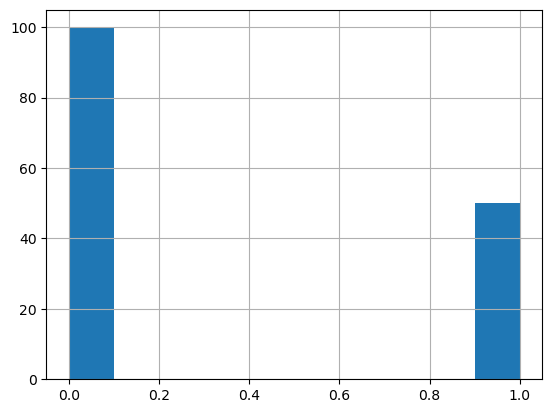

In [316]:
data = pd.read_csv("C:\\Users\\DELL\\Iris.csv") #lấy data từ local
X = data.drop("Species",axis=1) #lấy features
y =  data["Species"].apply(lambda x: 1 if x == "Iris-setosa" else 0) 
# target của chúng ta là Iris-setosa sẽ bằng 1 còn lại bằng 0  
y.hist() # thống kê species 
plt.show()

#### **Train test split** 

In [317]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2) #chia train và test 80/20
rdf = RandomForestClasifier()
rdf.fit(X_train.values,y_train.values)
y_pred = rdf.predict(X_test)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


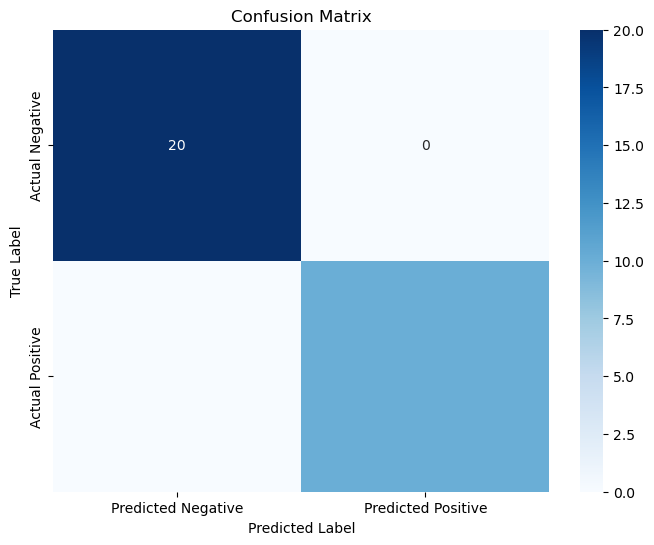

In [318]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [319]:
#khởi tạo các metrics 
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
# dùng k fold kiểm tra chéo để đánh giá performance 

#tính giá trị trung bình của các sau k fold của các metrics 
dcScores = cross_validate(rdf,X_test.values,y_test.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
#tính k fold của train test để lát so sánh
dcScores_train= cross_validate(rdf,X_train.values,y_train.values,cv=StratifiedKFold(10),scoring=scoring_metrics)

Mean Accuracy: 0.97
Mean Precision: 0.98
Mean Recall: 0.97


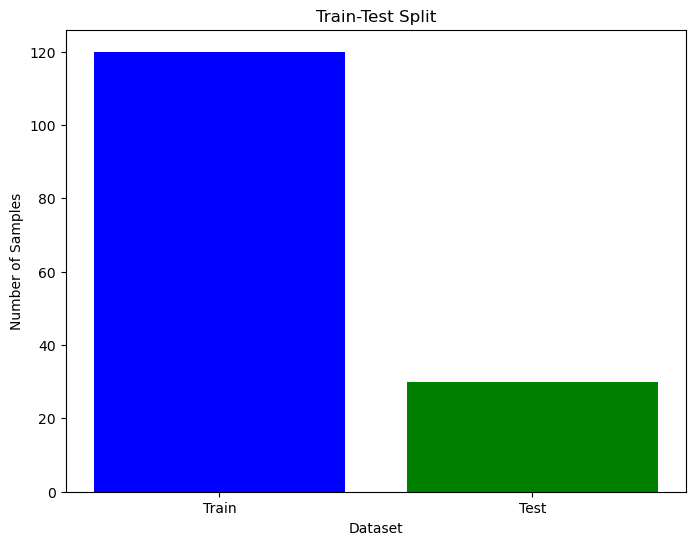

In [320]:
train_samples = len(X_train)
test_samples = len(X_test)

# Tạo biểu đồ
plt.figure(figsize=(8, 6))
plt.bar(["Train", "Test"], [train_samples, test_samples], color=['blue', 'green'])
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.title("Train-Test Split")
plt.show()

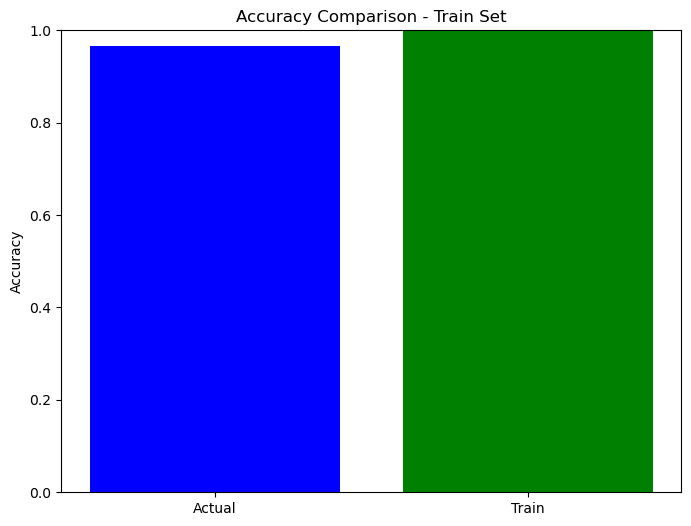

In [321]:

# Tính giá trị trung bình của các mảng
mean_test_accuracy_actual = np.mean(dcScores['test_accuracy'])
mean_test_accuracy_predicted = np.mean(dcScores_train['test_accuracy'])

# Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 6))
plt.bar(["Actual", "Train"], [mean_test_accuracy_actual, mean_test_accuracy_predicted], color=['blue', 'green'])
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison - Train Set")
plt.show()
